In [1]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

Streaming output truncated to the last 5000 lines.
  inflating: /data/test/Elmar_Brok_30.jpg  
  inflating: /data/test/Elmar_Brok_31.jpg  
  inflating: /data/test/Elsa_Zylberstein_00.jpg  
  inflating: /data/test/Elsa_Zylberstein_01.jpg  
  inflating: /data/test/Elsa_Zylberstein_10.jpg  
  inflating: /data/test/Elsa_Zylberstein_11.jpg  
  inflating: /data/test/Elsa_Zylberstein_40.jpg  
  inflating: /data/test/Elsa_Zylberstein_41.jpg  
  inflating: /data/test/Elton_John_10.jpg  
  inflating: /data/test/Elton_John_11.jpg  
  inflating: /data/test/Elton_John_20.jpg  
  inflating: /data/test/Elton_John_21.jpg  
  inflating: /data/test/Elton_John_30.jpg  
  inflating: /data/test/Elton_John_31.jpg  
  inflating: /data/test/Elton_John_40.jpg  
  inflating: /data/test/Elton_John_41.jpg  
  inflating: /data/test/Emile_Lahoud_00.jpg  
  inflating: /data/test/Emile_Lahoud_01.jpg  
  inflating: /data/test/Emile_Lahoud_30.jpg  
  inflating: /data/test/Emile_Lahoud_31.jpg  
  inflating: /data/test/E

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [3]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [6]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


In [7]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [8]:
batch_size = 50

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [9]:
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [11]:
# load test data in batches
batch_size = 50

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [12]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1=nn.Conv2d(1,16,7)
          self.conv2=nn.Conv2d(16,32,5)
          self.conv3=nn.Conv2d(32,64,5)
          #self.conv4=nn.Conv2d(128,256,3)
          self.pool=nn.MaxPool2d(3,3)
          self.bn1=nn.BatchNorm2d(16)
          self.bn2=nn.BatchNorm2d(32)
          self.bn3=nn.BatchNorm2d(64)
          #self.bn4=nn.BatchNorm2d(256)
          #self.drop=nn.Dropout(p=0.4)
          self.fc1=nn.Linear(64*6*6,800)
          self.fc2=nn.Linear(800,136)

      def forward(self,x):
          x=self.bn1(F.relu(self.conv1(x)))
          #print(x.shape) 
          x=self.pool(x)
          #print(x.shape) 
          x=self.bn2(F.relu(self.conv2(x))) 
          #print(x.shape)
          x=self.pool(x)
          #print(x.shape)
          x=self.bn3(F.relu(self.conv3(x))) 
          #print(x.shape)
          x=self.pool(x)
          #print(x.shape)
          #x=self.bn4(F.relu(self.conv4(x))) 
          #print(x.shape)
          x=self.fc1(x.view(-1,64*6*6))
          #x=self.drop(x)
          x=self.fc2(x)
          return x

n=Net()              

In [13]:
n
import torch.optim as optim
criterion=nn.MSELoss()
optimizer = optim.Adam(n.parameters(), lr = 0.0001)

In [ ]:
data=iter(train_loader)
d=next(data)
sample=d['image']
print(len(sample))

80


In [14]:
loss_overall=[]
for i in range(30):
  running_loss=0.0
  for data in train_loader:
      sample=data
      len 
      img=sample['image']
      key_pts=sample['keypoints']
      key_pts=key_pts.view(key_pts.size()[0],-1)
      key_pts = key_pts.type(torch.FloatTensor)
      img = img.type(torch.FloatTensor)
      optimizer.zero_grad()
      output=n(img)
      loss=criterion(output,key_pts)
      loss.backward()
      optimizer.step()
      running_loss+=loss
  running_loss/=50
  loss_overall.append(running_loss)
  print(f"epoch : {i} loss : {running_loss}")    
  

epoch : 0 loss : 0.3695914149284363
epoch : 1 loss : 0.20547407865524292
epoch : 2 loss : 0.1679113209247589
epoch : 3 loss : 0.1523333042860031
epoch : 4 loss : 0.1352413296699524
epoch : 5 loss : 0.12240482121706009
epoch : 6 loss : 0.11330532282590866
epoch : 7 loss : 0.10779093950986862
epoch : 8 loss : 0.1092124953866005
epoch : 9 loss : 0.10081999748945236
epoch : 10 loss : 0.11620166152715683
epoch : 11 loss : 0.11264970153570175
epoch : 12 loss : 0.10358615219593048
epoch : 13 loss : 0.10106436908245087
epoch : 14 loss : 0.09704191982746124
epoch : 15 loss : 0.08299796283245087
epoch : 16 loss : 0.08626315742731094
epoch : 17 loss : 0.08272615075111389
epoch : 18 loss : 0.07887859642505646
epoch : 19 loss : 0.08903279155492783
epoch : 20 loss : 0.07924845814704895
epoch : 21 loss : 0.08103367686271667
epoch : 22 loss : 0.07108841091394424
epoch : 23 loss : 0.07823100686073303
epoch : 24 loss : 0.08517850190401077
epoch : 25 loss : 0.07197939604520798
epoch : 26 loss : 0.0747055

In [15]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [16]:
def visualize_output(image_test, predicted_key_pts_test, gt_pts=None, batch_size=10):

  #  for i in range(batch_size):
        
    plt.figure(figsize=(20,10))
    image=image_test[0].data
    # un-transform the predicted key_pts data


    # un-transform the image data
    image = image.numpy()   # convert to numpy array from a Tensor
    print(image.shape)
    image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

    # un-transform the predicted key_pts data
    predicted_key_pts =predicted_key_pts_test[0].data
    predicted_key_pts = predicted_key_pts.numpy()
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*50+100
        
    
    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image), predicted_key_pts)
            
    

    plt.show()

In [17]:
for data in test_loader:
    img=data['image']
    key_pts=data['keypoints']
    # convert images to FloatTensors
    images = img.type(torch.FloatTensor)

    # forward pass to get net output
    output_pts = n(images)
        
    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
    # break after first image is tested
    break

(1, 224, 224)


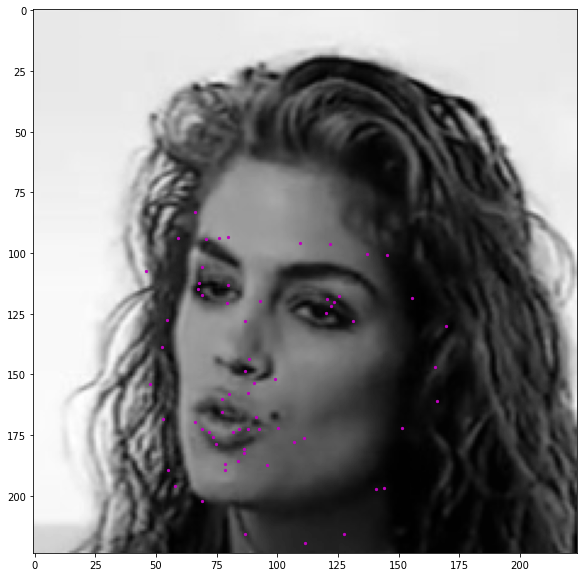

In [18]:
visualize_output(images,output_pts,key_pts)